 ALGORITMO GENETICO TRADICIONAL PARA 
LA SOLUCION DEL PROBLEMA DE LAS CIUDADES   

In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import math

In [82]:
data = pd.read_excel('Ciudades.xlsx')
data.describe()

,x,y
count,28.000000,28.000000
mean,52.214286,40.964286
std,27.312129,28.356830
min,10.000000,5.000000
25%,29.500000,16.000000
50%,54.000000,32.000000
75%,77.250000,57.500000
max,99.000000,99.000000


In [83]:
data.head(5)

,Ciudad,x,y
0,A,10,12
1,B,12,16
2,C,22,22
3,D,30,30
4,E,35,28


In [84]:
data = data.dropna(axis=0, how='any', ignore_index=True)
data.head(100)


,Ciudad,x,y
0,A,10,12
1,B,12,16
2,C,22,22
3,D,30,30
4,E,35,28
5,F,53,15
6,G,39,9
7,H,45,16
8,I,61,5
9,J,69,23


In [85]:
#data.count()
test =  data.loc[data['Ciudad'] == 'A']
print(test.iloc[0]['x'])
print(test.iloc[0]['y'])



10
12


In [86]:
lbls = data.iloc[:,0].values
x = data.iloc[:, 1]
y = data.iloc[:, 2]
print(lbls)
print(x)
print(y)


['A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'J' 'K' 'L' 'M' 'N' 'O' 'P' 'Q' 'R'
 'S' 'T' 'U' 'V' 'W' 'X' 'Y' 'Z' 'AA' 'AB']
0     10
1     12
2     22
3     30
4     35
5     53
6     39
7     45
8     61
9     69
10    78
11    85
12    12
13    16
14    28
15    28
16    62
17    95
18    84
19    64
20    31
21    55
22    45
23    57
24    90
25    77
26    99
27    80
Name: x, dtype: int64
0     12
1     16
2     22
3     30
4     28
5     15
6      9
7     16
8      5
9     23
10    15
11    17
12    32
13    42
14    56
15    12
16    55
17    32
18    53
19    36
20    62
21    70
22    55
23    91
24    99
25    65
26    99
27    80
Name: y, dtype: int64


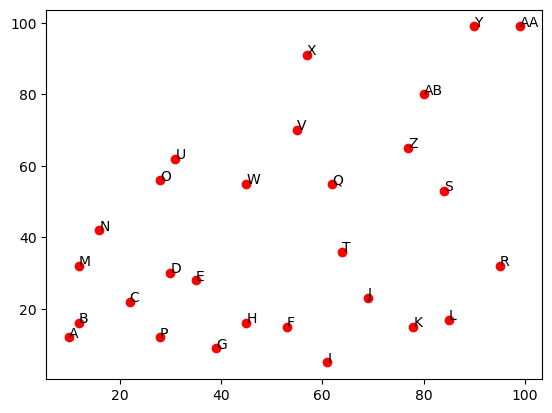

In [87]:
fig, ax = plt.subplots()
ax.plot(x,y,'ro')
for i, text in enumerate(lbls):
    ax.text(x[i],y[i],text)
plt.show()

# Se inicia con el desarrollo del algoritmo genetico

#### Generar poblacion aleatoria

In [88]:
def generarPoblacionAleatoria(tam_poblacion,labels):
    poblacion = []
    num_ciudades = len(lbls)
    for i in range(tam_poblacion):
        individuo = []
        while(len(individuo) <num_ciudades):
        #for j in range(num_ciudades):
            label = random.choice(labels)
            if label not in individuo:
                individuo.append(label)
        individuo.append(individuo[0]) #linea para agregar al individuo la primer letra 
        poblacion.append(individuo)
        #print(individuo)
    return poblacion

### Evaluar la poblacion

In [89]:
def fitness(poblacion,x,y,data):
    distancias = []
    
    for individuo in poblacion:
        distancia = 0
        #print("individo")
        #print(individuo)
        for i in range(len(individuo)-1):
            ind1 = data.loc[data['Ciudad'] == individuo[i]]
            ind2 = data.loc[data['Ciudad'] == individuo[i+1]]
            xind1 = ind1.iloc[0]['x']
            yind1 = ind1.iloc[0]['y']
            xind2 = ind2.iloc[0]['x']
            yind2 = ind2.iloc[0]['y']
            
            dist = math.sqrt((xind2-xind1)**2+(yind2-yind1)**2)
            #print(dist)
            distancia +=dist
        distancias.append(distancia)
            
            
    return distancias
        

In [90]:
def selection(poblacion,distancias):
    combinados = list(zip(distancias, poblacion))
    combinados_ordenados = sorted(combinados)
    dist, pob = zip(*combinados_ordenados)
    
    return pob[0:int(len(poblacion)/2)],dist[0:int(len(poblacion)/2)]
    

In [91]:
def seleccion_torneo(poblacion, distancias, k=3):
    seleccionados = []
    distancias_selec = []
    for _ in range(len(poblacion) // 2):
        torneo = random.sample(list(zip(poblacion, distancias)), k)
        ganador = max(torneo, key=lambda x: x[1])
        seleccionados.append(ganador[0])
        distancias_selec.append(ganador[1])
    return seleccionados, distancias_selec

In [92]:
def quitarDuplicados(hijo,lbls):
    hijo = hijo[:-1]
    #FUNCION PARA QUITAR LAS LETRAS DUPLICADAS Y COLOCAR LAS FALTANTES
    letras_usadas = set(hijo) 
    #print(hijo,letras_usadas)
    letras_faltantes = []
    for letra in lbls:
        if letra not in letras_usadas:
            letras_faltantes.append(letra)
    res = []
    for letra in hijo:
        if letra in letras_usadas:
            res.append(letra)
            letras_usadas.remove(letra)
        else:
            res.append(None)
    #la lista tiene posiciones vacias donde hay repetidos
    id = 0
    for i in range(len(res)):
        if res[i] is None:
            res[i] = letras_faltantes[id]
            id +=1
    res.append(res[0])
    return res
        
            

In [93]:
def cruza_mutacion(progenitores,prob_cruza,prob_muta,lbls):
    hijos_nuevos = []
    for i in range(0,len(progenitores)-1,2):
        
        #seleccion de los padres
        padre1 = progenitores[i]
        padre2 = progenitores[i+1]
        
        if random.random() <= prob_cruza:
            print("Generando cruza")
            #seleccion punto de cruza
            punto1 = random.randint(1, len(padre1)-2)
            punto2 = random.randint(punto1+1, len(padre1)-1)    
            
            #creacion de hijos
            hijo1 = padre1[:punto1] + padre2[punto1:punto2] + padre1[punto2:] 
            hijo2 = padre2[:punto1] + padre1[punto1:punto2] + padre2[punto2:]
            
            #quitar repetidos y colocar los faltantes
            #print("hijo1",hijo1)
            #print("hijo1 corto",hijo1[:-1])
            hijo1 = quitarDuplicados(hijo1,lbls)
            hijo2 = quitarDuplicados(hijo2,lbls)
            
            
        else: 
            hijo1 = padre1
            hijo2 = padre2
        
        if random.random() <= prob_muta:
            print("Generando muta hijo")
            punto_muta1 = random.randint(0,len(hijo1)-1)
            punto_muta2 = random.randint(0,len(hijo2)-1)
            aux1 = hijo1[punto_muta1]
            hijo1[punto_muta1] = hijo1[punto_muta2]
            hijo1[punto_muta2] = aux1
            aux2 = hijo2[punto_muta1]
            hijo2[punto_muta1] = hijo2[punto_muta2]
            hijo2[punto_muta2] = aux2
        if random.random() <= prob_muta:
            print("Generando muta padre")
            punto_muta1 = random.randint(0,len(hijo1)-1)
            punto_muta2 = random.randint(0,len(hijo2)-1)
            aux1 = padre1[punto_muta1]
            padre1[punto_muta1] = padre1[punto_muta2]
            padre1[punto_muta2] = aux1
            aux2 = padre2[punto_muta1]
            padre2[punto_muta1] = padre2[punto_muta2]
            padre2[punto_muta2] = aux2
        #AGREGO NUEVOS HIJOS A LA LISTA  
        
        hijos_nuevos.append(hijo1)
        hijos_nuevos.append(hijo2)
        hijos_nuevos.append(padre1)
        hijos_nuevos.append(padre2)
    
    return hijos_nuevos
        
        
        

In [94]:
#pob = poblacion[0][:-1]
#print(poblacion[0])
#print(pob)

# funcion principal


In [95]:
#generar poblacion aleatoria
tam_poblacion = 20
probabilidad_cruza = 0.5
probabilidad_muta = 0.0
generaciones = 100


poblacion = generarPoblacionAleatoria(tam_poblacion,lbls)
#evaluacion de la poblacion
distancias = fitness(poblacion,x,y,data)
#seleccion
seleccionados,distancias_seleccionados = selection(poblacion,distancias)
#print(len(seleccionados))
#cruza y mutacion
nuevos_hijos = cruza_mutacion(seleccionados,probabilidad_cruza,probabilidad_muta,lbls)

#unir poblacion final
poblacion = list(seleccionados)+nuevos_hijos
print(distancias[0])



1561.6943341094038


In [96]:
punto1 = random.randint(1, len(seleccionados[0])-2)
punto2 = random.randint(punto1+1, len(seleccionados[0])-1)
print(punto1,punto2,len(seleccionados[0]))

26 27 29


In [97]:
#generar poblacion aleatoria
tam_poblacion = 400
probabilidad_cruza = 0.75
probabilidad_muta = 0.15
generaciones = 500

poblacion = generarPoblacionAleatoria(tam_poblacion,lbls)
num_generaciones = 0

mejor_individuo = []
mejor_distancia = 0
hist_individuos = []
hist_distancias = []
while(num_generaciones < generaciones):
    
    #evaluacion de la poblacion
    distancias = fitness(poblacion,x,y,data)
    #seleccion
    seleccionados,distancias_seleccionados = selection(poblacion,distancias)
    #seleccionados,distancias_seleccionados = seleccion_torneo(poblacion,distancias,k=7)
    #print(len(seleccionados))
    #cruza y mutacion
    poblacion = cruza_mutacion(seleccionados,probabilidad_cruza,probabilidad_muta, lbls)
    
    #distancias = fitness(poblacion,x,y,data)
    #seleccionados,distancias_seleccionados = seleccion_torneo(poblacion,distancias,k=3)
    mejor_individuo = seleccionados[0]
    mejor_distancia = distancias_seleccionados[0]
    
    hist_individuos.append(mejor_individuo)
    hist_distancias.append(mejor_distancia)
    
    print("GENERACION ---{} MEJOR DISTANCIA----{} POBLACION---{}".format(num_generaciones,mejor_distancia,len(seleccionados)))
    num_generaciones += 1
    
    


Generando muta hijo
Generando muta padre
Generando muta padre
Generando muta hijo
Generando muta hijo
Generando muta hijo
Generando muta hijo
Generando muta hijo
Generando muta padre
Generando muta padre
Generando muta hijo
Generando muta hijo
Generando muta padre
Generando muta padre
Generando muta hijo
Generando muta padre
Generando muta hijo
Generando muta padre
Generando muta hijo
Generando muta hijo
Generando muta padre
Generando muta padre
Generando muta hijo
Generando muta padre
Generando muta hijo
Generando muta hijo
Generando muta padre
Generando muta padre
Generando muta hijo
Generando muta hijo
GENERACION ---0 MEJOR DISTANCIA----1002.8911123714024 POBLACION---200
Generando muta padre
Generando muta hijo
Generando muta padre
Generando muta padre
Generando muta padre
Generando muta padre
Generando muta hijo
Generando muta hijo
Generando muta padre
Generando muta padre
Generando muta hijo
Generando muta padre
Generando muta padre
Generando muta hijo
Generando muta hijo
Generand

In [98]:
print(mejor_distancia)
print(mejor_individuo)
#obtener x y de cada individuo 
x = []
y = []
for gen in mejor_individuo:
    x.append(data[data['Ciudad'] == gen].iloc[0]['x'])
    y.append(data[data['Ciudad'] == gen].iloc[0]['y'])
#print(y)
    


482.3663966905484
['AA', 'AB', 'Z', 'S', 'O', 'N', 'M', 'D', 'E', 'C', 'B', 'A', 'P', 'G', 'H', 'F', 'I', 'K', 'L', 'R', 'J', 'T', 'Q', 'W', 'U', 'V', 'X', 'Y', 'AA']


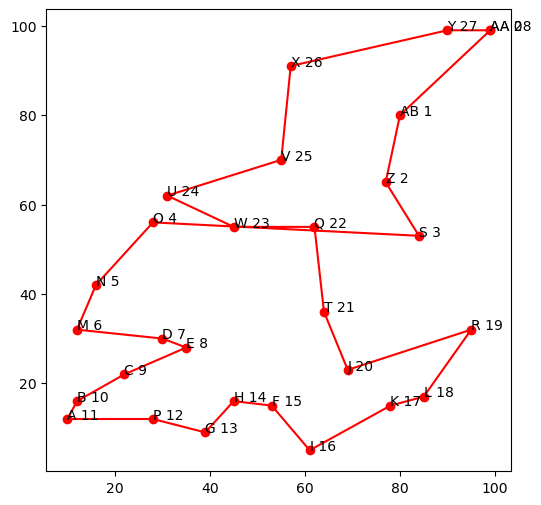

In [99]:
fig, ax = plt.subplots(figsize=(6,6))
ax.plot(x,y,'-ro')
cont = 0
for i, text in enumerate(mejor_individuo):
    txt = text+" "+str(cont)
    ax.text(x[i],y[i],txt)
    cont +=1
plt.show()

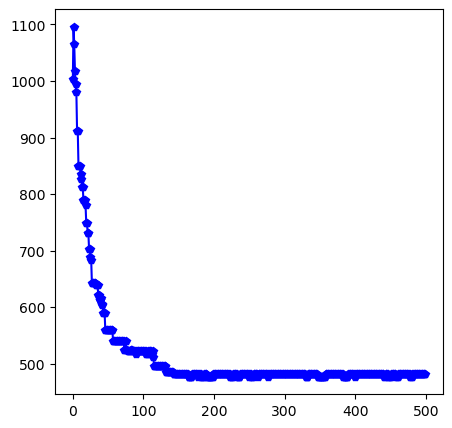

In [100]:
fig, ax = plt.subplots(figsize=(5,5))
ax.plot(hist_distancias,'-bp')
plt.show()